In [1]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

%matplotlib inline

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

In [2]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(epoc_files = files, first_n=len(files)) #first_n = 500 by default. Apply first_n = len(files) to load all

Loading epoc data...


100%|██████████| 65034/65034 [01:46<00:00, 612.27it/s]


In [3]:
print("Num points EPOC:", len(all_points))
print("Num labels EPOC:", len(all_labels))
print("Labels EPOC:", all_labels)
print("------------------------------------")
print("Data shape EPOC", all_points[0].raw_data.shape)

Num points EPOC: 64629
Num labels EPOC: 11
Labels EPOC: ['5', '2', '4', '1', '8', '3', '7', '6', '9', '-1', '0']
------------------------------------
Data shape EPOC (256, 14)


In [4]:
for point in tqdm(all_points):
    point.full_clean(channels=['T7', 'P7', 'P8', 'T8'])

100%|██████████| 64629/64629 [02:24<00:00, 448.68it/s]


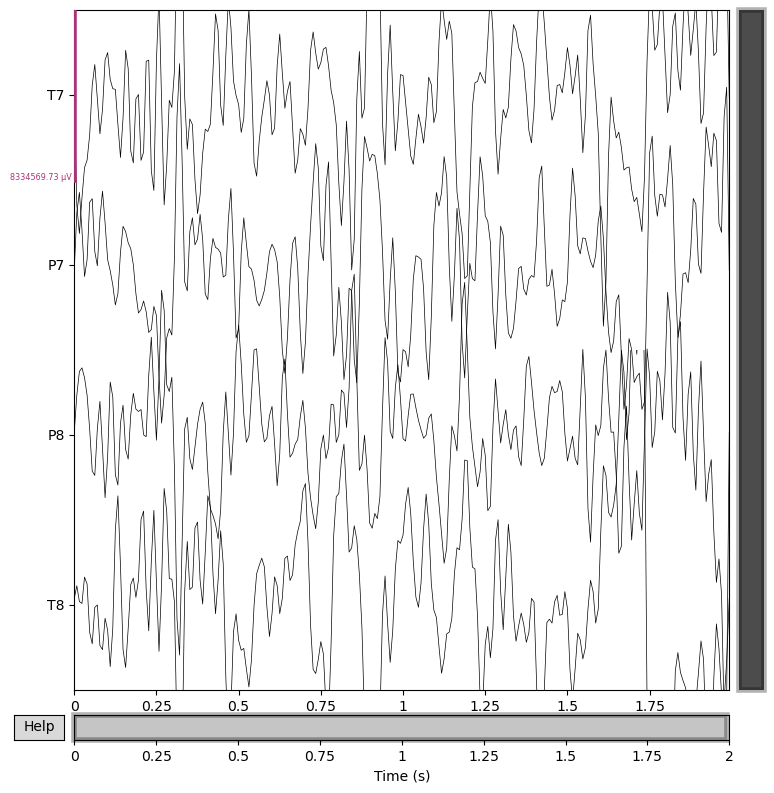

In [5]:
all_points[0].mne_object.plot(scalings = 'auto');

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
from torch.optim import Adam, SGD
import torch.nn as nn
from torch.nn import MSELoss, CrossEntropyLoss
from models.EegClassifierA import Classifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
batch_size = 32
num_workers = 4

dataset = EegDataset(data_points=all_points, labels=all_labels)
train, test = train_test_split(dataset, train_size=0.8, shuffle=True)

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model = Classifier(classes_count=11).to(device=device)

optimizer = Adam(model.parameters(), lr=0.01)
loss_function = CrossEntropyLoss()

n_epochs = 100

validation_data = []
training_data = []

for epoch in range(n_epochs):
    
    print(f'Epoch {epoch+1}/{n_epochs}')
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0

    for data, labels in tqdm(train_dataloader):
        
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(data)

        #Prediction
        answers = list()
        for i in labels:
            answers.append(((i == 1).nonzero(as_tuple=True)[0]))
        answers = torch.Tensor(answers).to(device)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy+=int(torch.sum(prediction==answers))

        #Loss
        loss = loss_function(outputs, labels)
        loss.backward()
        train_loss += loss.cpu().data
        optimizer.step()
    
    train_loss/=(len(train_dataloader))
    train_accuracy/=(len(train_dataloader) * batch_size)
    training_data.append(train_loss.item())

    print('Epoch train loss:', train_loss.item())
    print('Epoch accuracy:', train_accuracy)

    print("------------------Validating--------------------")
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        
        outputs = model(data)
        #Accuracy
        answers = list()
        for i in labels:
            answers.append(((i == 1).nonzero(as_tuple=True)[0]))
        answers = torch.Tensor(answers).to(device)
        _, prediction = torch.max(outputs.data, 1)
        val_accuracy+=int(torch.sum(prediction==answers))
        #Loss
        val_loss += loss_function(outputs, labels)


    val_loss /= len(test_dataloader)
    val_accuracy /= (len(test_dataloader)*batch_size)
    validation_data.append(val_loss.item())
    print('Validation loss:',val_loss.item())
    print('Validation accuracy:',val_accuracy)

cuda
Epoch 1/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.319277286529541
Epoch accuracy: 0.09966738861386139
------------------Validating--------------------
Validation loss: 2.315932035446167
Validation accuracy: 0.09870049504950495
Epoch 2/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.316396951675415
Epoch accuracy: 0.09858446782178218
------------------Validating--------------------
Validation loss: 2.314042806625366
Validation accuracy: 0.09831373762376237
Epoch 3/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3157663345336914
Epoch accuracy: 0.0988745358910891
------------------Validating--------------------
Validation loss: 2.3149683475494385
Validation accuracy: 0.09870049504950495
Epoch 4/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158040046691895
Epoch accuracy: 0.10040222772277228
------------------Validating--------------------
Validation loss: 2.314533233642578
Validation accuracy: 0.09870049504950495
Epoch 5/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158364295959473
Epoch accuracy: 0.0994740099009901
------------------Validating--------------------
Validation loss: 2.3144497871398926
Validation accuracy: 0.09870049504950495
Epoch 6/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158740997314453
Epoch accuracy: 0.10028620049504951
------------------Validating--------------------
Validation loss: 2.3135018348693848
Validation accuracy: 0.10225866336633663
Epoch 7/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158318996429443
Epoch accuracy: 0.09986076732673267
------------------Validating--------------------
Validation loss: 2.3158302307128906
Validation accuracy: 0.10024752475247525
Epoch 8/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.315744400024414
Epoch accuracy: 0.10067295792079207
------------------Validating--------------------
Validation loss: 2.3157334327697754
Validation accuracy: 0.0952970297029703
Epoch 9/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158206939697266
Epoch accuracy: 0.10198793316831684
------------------Validating--------------------
Validation loss: 2.313950777053833
Validation accuracy: 0.09870049504950495
Epoch 10/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3156962394714355
Epoch accuracy: 0.09812035891089109
------------------Validating--------------------
Validation loss: 2.314621925354004
Validation accuracy: 0.10024752475247525
Epoch 11/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.316009759902954
Epoch accuracy: 0.10007348391089109
------------------Validating--------------------
Validation loss: 2.3144242763519287
Validation accuracy: 0.09870049504950495
Epoch 12/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3157572746276855
Epoch accuracy: 0.09912592821782178
------------------Validating--------------------
Validation loss: 2.313873767852783
Validation accuracy: 0.10225866336633663
Epoch 13/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.315797805786133
Epoch accuracy: 0.09929996905940594
------------------Validating--------------------
Validation loss: 2.3135204315185547
Validation accuracy: 0.10357363861386139
Epoch 14/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3156187534332275
Epoch accuracy: 0.09991878094059406
------------------Validating--------------------
Validation loss: 2.3137588500976562
Validation accuracy: 0.10357363861386139
Epoch 15/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.315927267074585
Epoch accuracy: 0.09858446782178218
------------------Validating--------------------
Validation loss: 2.3136701583862305
Validation accuracy: 0.10357363861386139
Epoch 16/100


  0%|          | 0/1616 [00:00<?, ?it/s]

Epoch train loss: 2.3158326148986816
Epoch accuracy: 0.09995745668316831
------------------Validating--------------------
Validation loss: 2.313559055328369
Validation accuracy: 0.10063428217821782
Epoch 17/100


  0%|          | 0/1616 [00:00<?, ?it/s]

KeyboardInterrupt: 

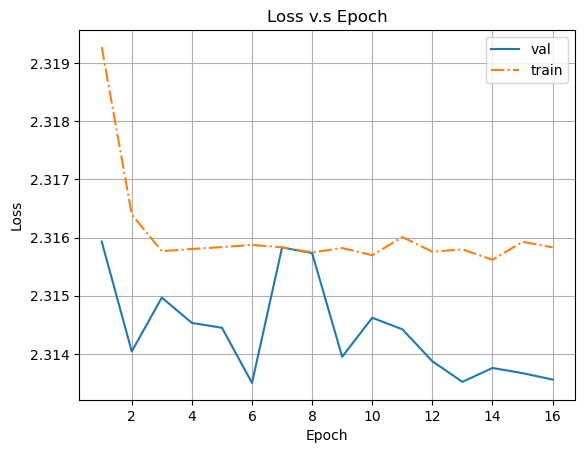

In [19]:
x = [i+1 for i in range(len(validation_data))]

plt.plot(x, validation_data, label ='val')
plt.plot(x, training_data, '-.', label ='train')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Loss v.s Epoch')
plt.grid()

plt.show()